### OCI Data Science - Useful Tips
Everything stored in the <span style="background-color: #d5d8dc ">/home/datascience</span> folder is now stored on your block volume drive. The <span style="background-color: #d5d8dc ">ads-examples</span> folder has moved outside of your working space. Notebook examples are now accessible through a Launcher tab "Notebook Examples" button.
<details>
<summary><font size="2">1. Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">2. OCI Configuration and Key Files Set Up</font></summary><p>Follow the instructions in the getting-started notebook. That notebook is accessible via the "Getting Started" Launcher tab button.</p>
</details>
<details>
<summary><font size="2">3. Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">4. Typical Cell Imports and Settings</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import MLData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">5. Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [2]:
import sys
sys.path.append("/home/datascience/footballer_valuation/footballer_valuation/python/extractions/")
import sqlalchemy as db
import pandas as pd
import numpy as np
import os
import warnings as w
from Connection import Connection
from PlayerTMarkt import PlayerTMarkt
from Player import Player
from PlayerStats import PlayerStats
from Utils import Utils
import logging
import json
import requests
import sqlalchemy as db
import warnings as w
import os
import re
from sqlalchemy import (MetaData, Table, Column, Integer,Float,Date, select, literal, and_, exists,String)
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy.orm import relationship
from datetime import datetime
from multiprocessing import Pool
import unidecode
from sklearn.base import TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import get_scorer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score

w.filterwarnings("ignore",category=Warning)

os.environ['TNS_ADMIN']='/home/datascience/instantclient_19_5/network/admin/'
engine = db.create_engine('oracle://<user>:<password>@dbml19c_high')


In [384]:
con = Connection("mycon","oracle",20,"utf-8")
sql="""SELECT
    team_id,
    captain,
    game_appearences,
    games_minutes_played,
    games_lineups,
    substitutes_in,
    substitutes_out,
    substitutes_bench,
    goals_total,
    assists,
    conceded,
    saves,
    passes_total,
    key_pass,
    pass_accuracy,
    tackles_total,
    tackles_blocks,
    tackles_interceptions,
    duels_total,
    duels_won,
    dribbles_attempts,
    dribbles_success,
    fouls_drawn,
    fouls_commited,
    shots_total,
    shots_on,
    penalty_won,
    penalty_commited,
    penalty_success,
    penalty_missed,
    penalty_saved,
    yellow_card,
    yellowred,
    red_card,
    position,
    nationality,
    nvl(age,27)
    height,
    weight,
    lsispl lastSeasonPL,
    lsstats lastSeasonStats,
    plex plExperience,
    sumteamexp teamTenure,
    gpmdiffer statsChange,
    last3SeasonTeamChange,
    target1
FROM
    stg_dataset_premier_league"""
sess = con.create_oracle_session()

In [385]:
df = pd.read_sql(con=con.engine,sql=sql)
#features = ['games_minutes_played','game_appearences','team_id','last3seasonteamchange',
#            'red_card','position','substitutes_out','statschange','substitutes_in','penalty_saved','teamtenure','lastseasonstats',
#            'lastseasonpl','nationality','plexperience','target1']

features = ['games_minutes_played','game_appearences','team_id','last3seasonteamchange','saves','games_lineups','substitutes_out','substitutes_in',
            'teamtenure','lastseasonstats','lastseasonpl','nationality','statschange','plexperience','red_card','position','target1']

#features = ['games_minutes_played','game_appearences','team_id','last3seasonteamchange',
#            'red_card','position','substitutes_out','statschange','substitutes_in','penalty_saved','teamtenure','lastseasonstats',
#            'lastseasonpl','nationality','plexperience','target1']
df = df[features]
# #############################################################################
# Import some data to play with

X = df.iloc[:,:len(df.columns)-1]
y = df.iloc[:,len(df.columns)-1:len(df.columns)] 

#encoding
X['position'] = X['position'].astype('category')
X['position_cat'] = X['position'].cat.codes
X = X.drop('position', 1)

#encoding
X['nationality'] = X['nationality'].astype('category')
X['nationality_cat'] = X['nationality'].cat.codes
X = X.drop('nationality', 1)

#bining
X["games_lineups_cat"] = pd.cut(X["games_lineups"],10, precision=0, labels=[1,2,3,4,5,6,7,8,9,10])
X['games_lineups_cat'] = X['games_lineups_cat'].astype('int')
X = X.drop('games_lineups', 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

plt.figure(1)
plt.clf()

X_indices = np.arange(X.shape[-1])

<Figure size 640x480 with 0 Axes>

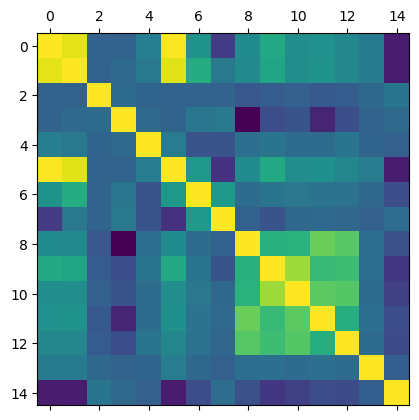

,games_minutes_played,game_appearences,team_id,last3seasonteamchange,saves,substitutes_out,substitutes_in,teamtenure,lastseasonstats,lastseasonpl,statschange,plexperience,red_card,position_cat,nationality_cat,games_lineups_cat
games_minutes_played,1.000000,0.937727,-0.026104,-0.021603,0.142498,0.267991,-0.233848,0.224818,0.417213,0.238621,0.257537,0.194650,0.124869,0.027592,-0.010377,0.984309
game_appearences,0.937727,1.000000,-0.036107,0.013443,0.098919,0.427639,0.097621,0.215049,0.385466,0.242674,0.264155,0.195389,0.119788,0.005281,-0.008210,0.913044
team_id,-0.026104,-0.036107,1.000000,0.022474,-0.015470,-0.024643,-0.025114,-0.094616,-0.061491,-0.042402,-0.086183,-0.061832,0.004343,0.003069,0.029711,-0.024598
last3seasonteamchange,-0.021603,0.013443,0.022474,1.000000,0.019549,0.089642,0.099051,-0.500887,-0.146702,-0.111151,-0.346690,-0.140486,-0.023409,-0.037807,0.002225,-0.031638
saves,0.142498,0.098919,-0.015470,0.019549,1.000000,-0.114736,-0.109972,0.046846,0.074534,0.030810,0.031408,0.082744,-0.018195,0.045230,-0.001640,0.142352
substitutes_out,0.267991,0.427639,-0.024643,0.089642,-0.114736,1.000000,0.304205,0.029963,0.076243,0.092362,0.070862,0.062526,0.003127,0.057366,-0.017768,0.280674
substitutes_in,-0.233848,0.097621,-0.025114,0.099051,-0.109972,0.304205,1.000000,-0.034932,-0.111064,-0.000328,0.012049,-0.006739,-0.038267,-0.086682,0.011132,-0.298208
teamtenure,0.224818,0.215049,-0.094616,-0.500887,0.046846,0.029963,-0.034932,1.000000,0.454206,0.455360,0.660125,0.611888,0.041692,0.032896,-0.009902,0.211740
lastseasonstats,0.417213,0.385466,-0.061491,-0.146702,0.074534,0.076243,-0.111064,0.454206,1.000000,0.780526,0.516247,0.531401,0.045547,0.018147,-0.032530,0.405432
lastseasonpl,0.238621,0.242674,-0.042402,-0.111151,0.030810,0.092362,-0.000328,0.455360,0.780526,1.000000,0.624522,0.605454,0.023192,0.012020,-0.036141,0.221825


In [386]:
import matplotlib.pyplot as plt

plt.matshow(df.corr())
plt.show()

X.corr()

MLPClassifier

In [387]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(150,100,50), random_state=1)

clf.fit(X_train, y_train)
print(clf)
# make predictions for test data

y_pred = clf.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(150, 100, 50), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)
Accuracy: 67.52%


XGBoost Classifier

In [388]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

xgboost = XGBClassifier()
xgboost.fit(X_train, y_train)

print(xgboost)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [389]:
# make predictions for test data
y_pred = xgboost.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 76.70%


Support Vector Machines

In [390]:
from sklearn import svm
svc = svm.SVC()
svc.fit(X_train, y_train)

print(svc)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


In [391]:
# make predictions for test data
y_pred = svc.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 68.72%


In [392]:
#from sklearn.model_selection import GridSearchCV
#parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
#clf = GridSearchCV(svc, parameters)
#clf.fit(X_train, y_train)
#sorted(clf.cv_results_.keys())

LGBMClassifier

In [393]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(n_estimators= 103,reg_alpha= 0.0001, reg_lambda= 0.9995, learning_rate=0.098)
lgbm.fit(X_train, y_train)

print(lgbm)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.098, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=103, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0001, reg_lambda=0.9995,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)


In [394]:
# make predictions for test data
y_pred = lgbm.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 78.44%


LogisticRegression

In [395]:
from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression(random_state=0).fit(X_train, y_train)
print(lgr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


In [396]:
# make predictions for test data
y_pred = lgr.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 72.75%


BaggingClassifier

In [397]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
bagging = BaggingClassifier(base_estimator=SVC(),n_estimators=10, random_state=0).fit(X_train, y_train)

In [398]:
# make predictions for test data
y_pred = bagging.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 68.53%


DecisionTreeClassifier

In [399]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
decisionTree = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
scores = cross_val_score(decisionTree, X_train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.67 (+/- 0.04)


In [400]:
y_pred = decisionTree.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 68.44%


KNeighborsClassifier

In [401]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

scores = cross_val_score(neigh, X_train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.69 (+/- 0.02)


In [402]:
y_pred = neigh.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 67.89%


ADS Evaluator

HTML(value='<style  type="text/css" >\n    #T_91881fae_3753_11eb_922c_5324a1481110  {\n          text-align: r…

HTML(value='<style  type="text/css" >\n    #T_91965c4a_3753_11eb_922c_5324a1481110  {\n          text-align: r…

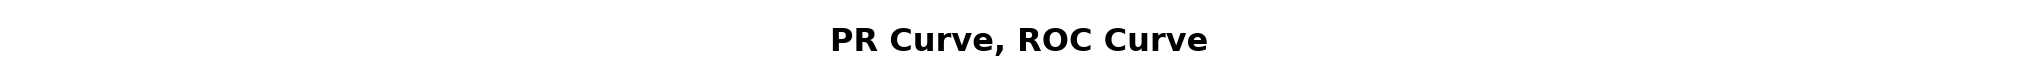

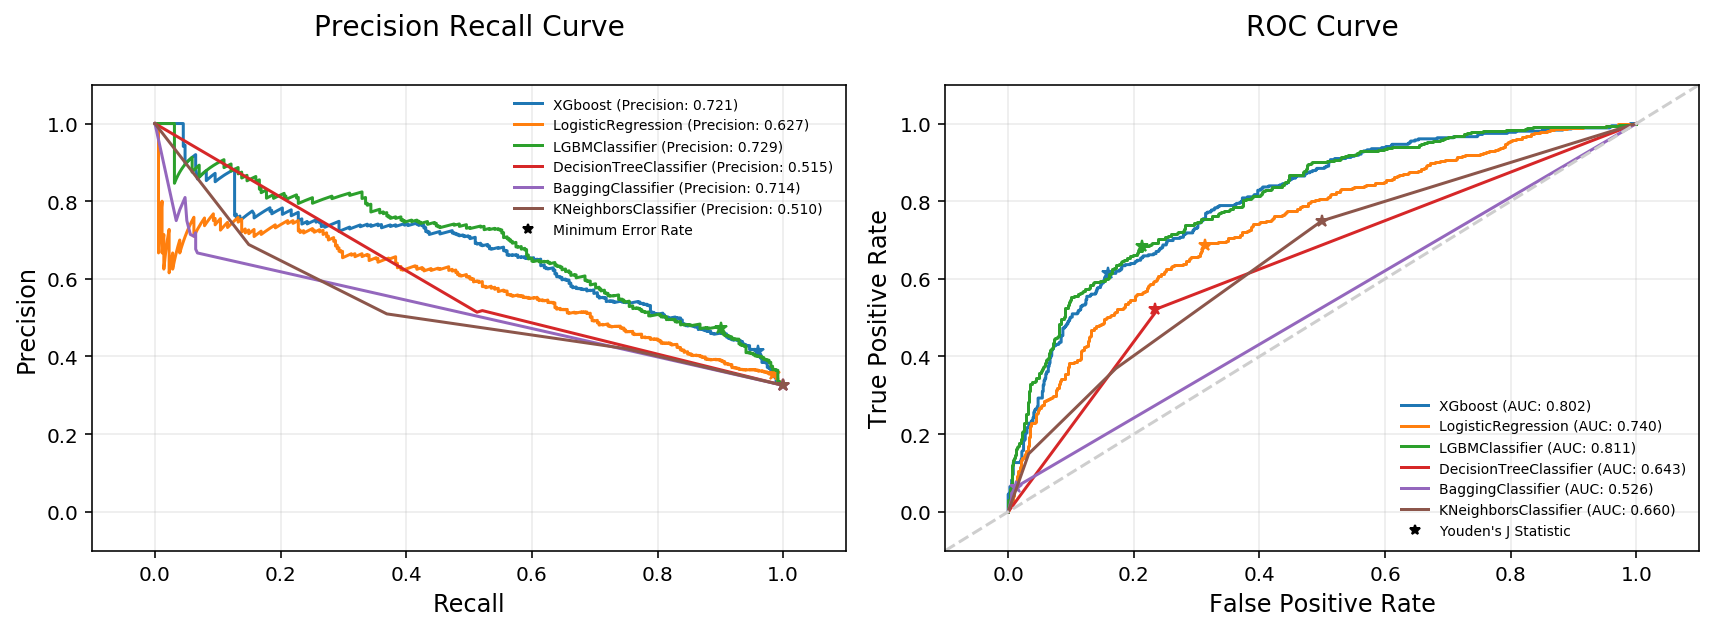

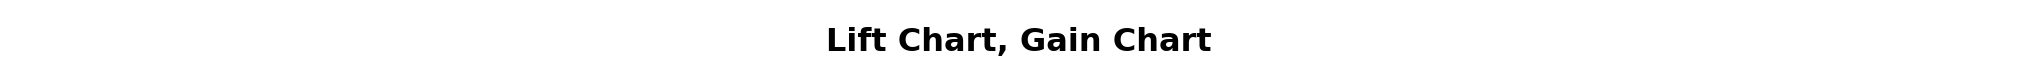

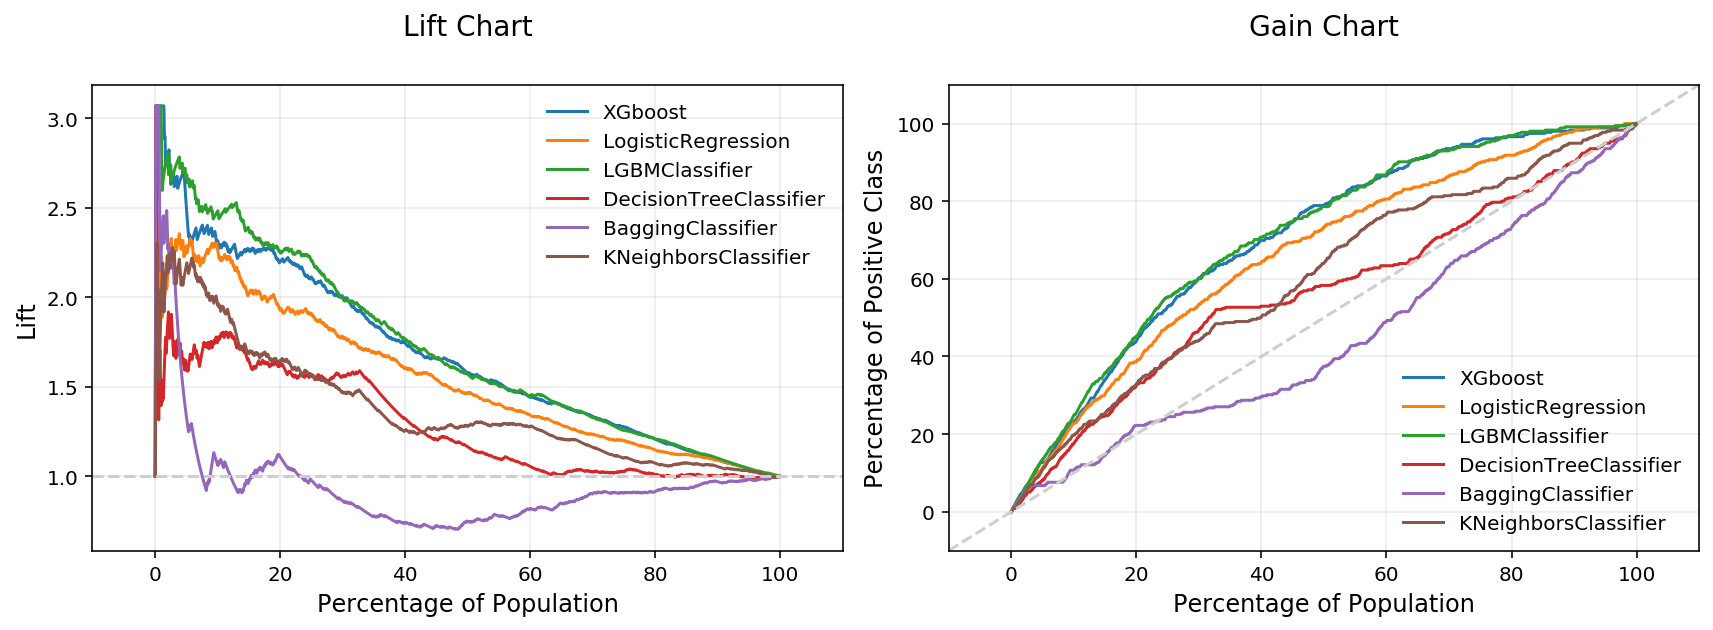

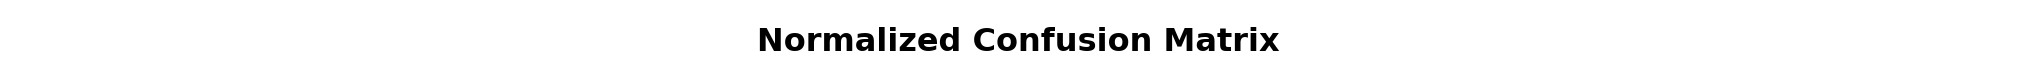

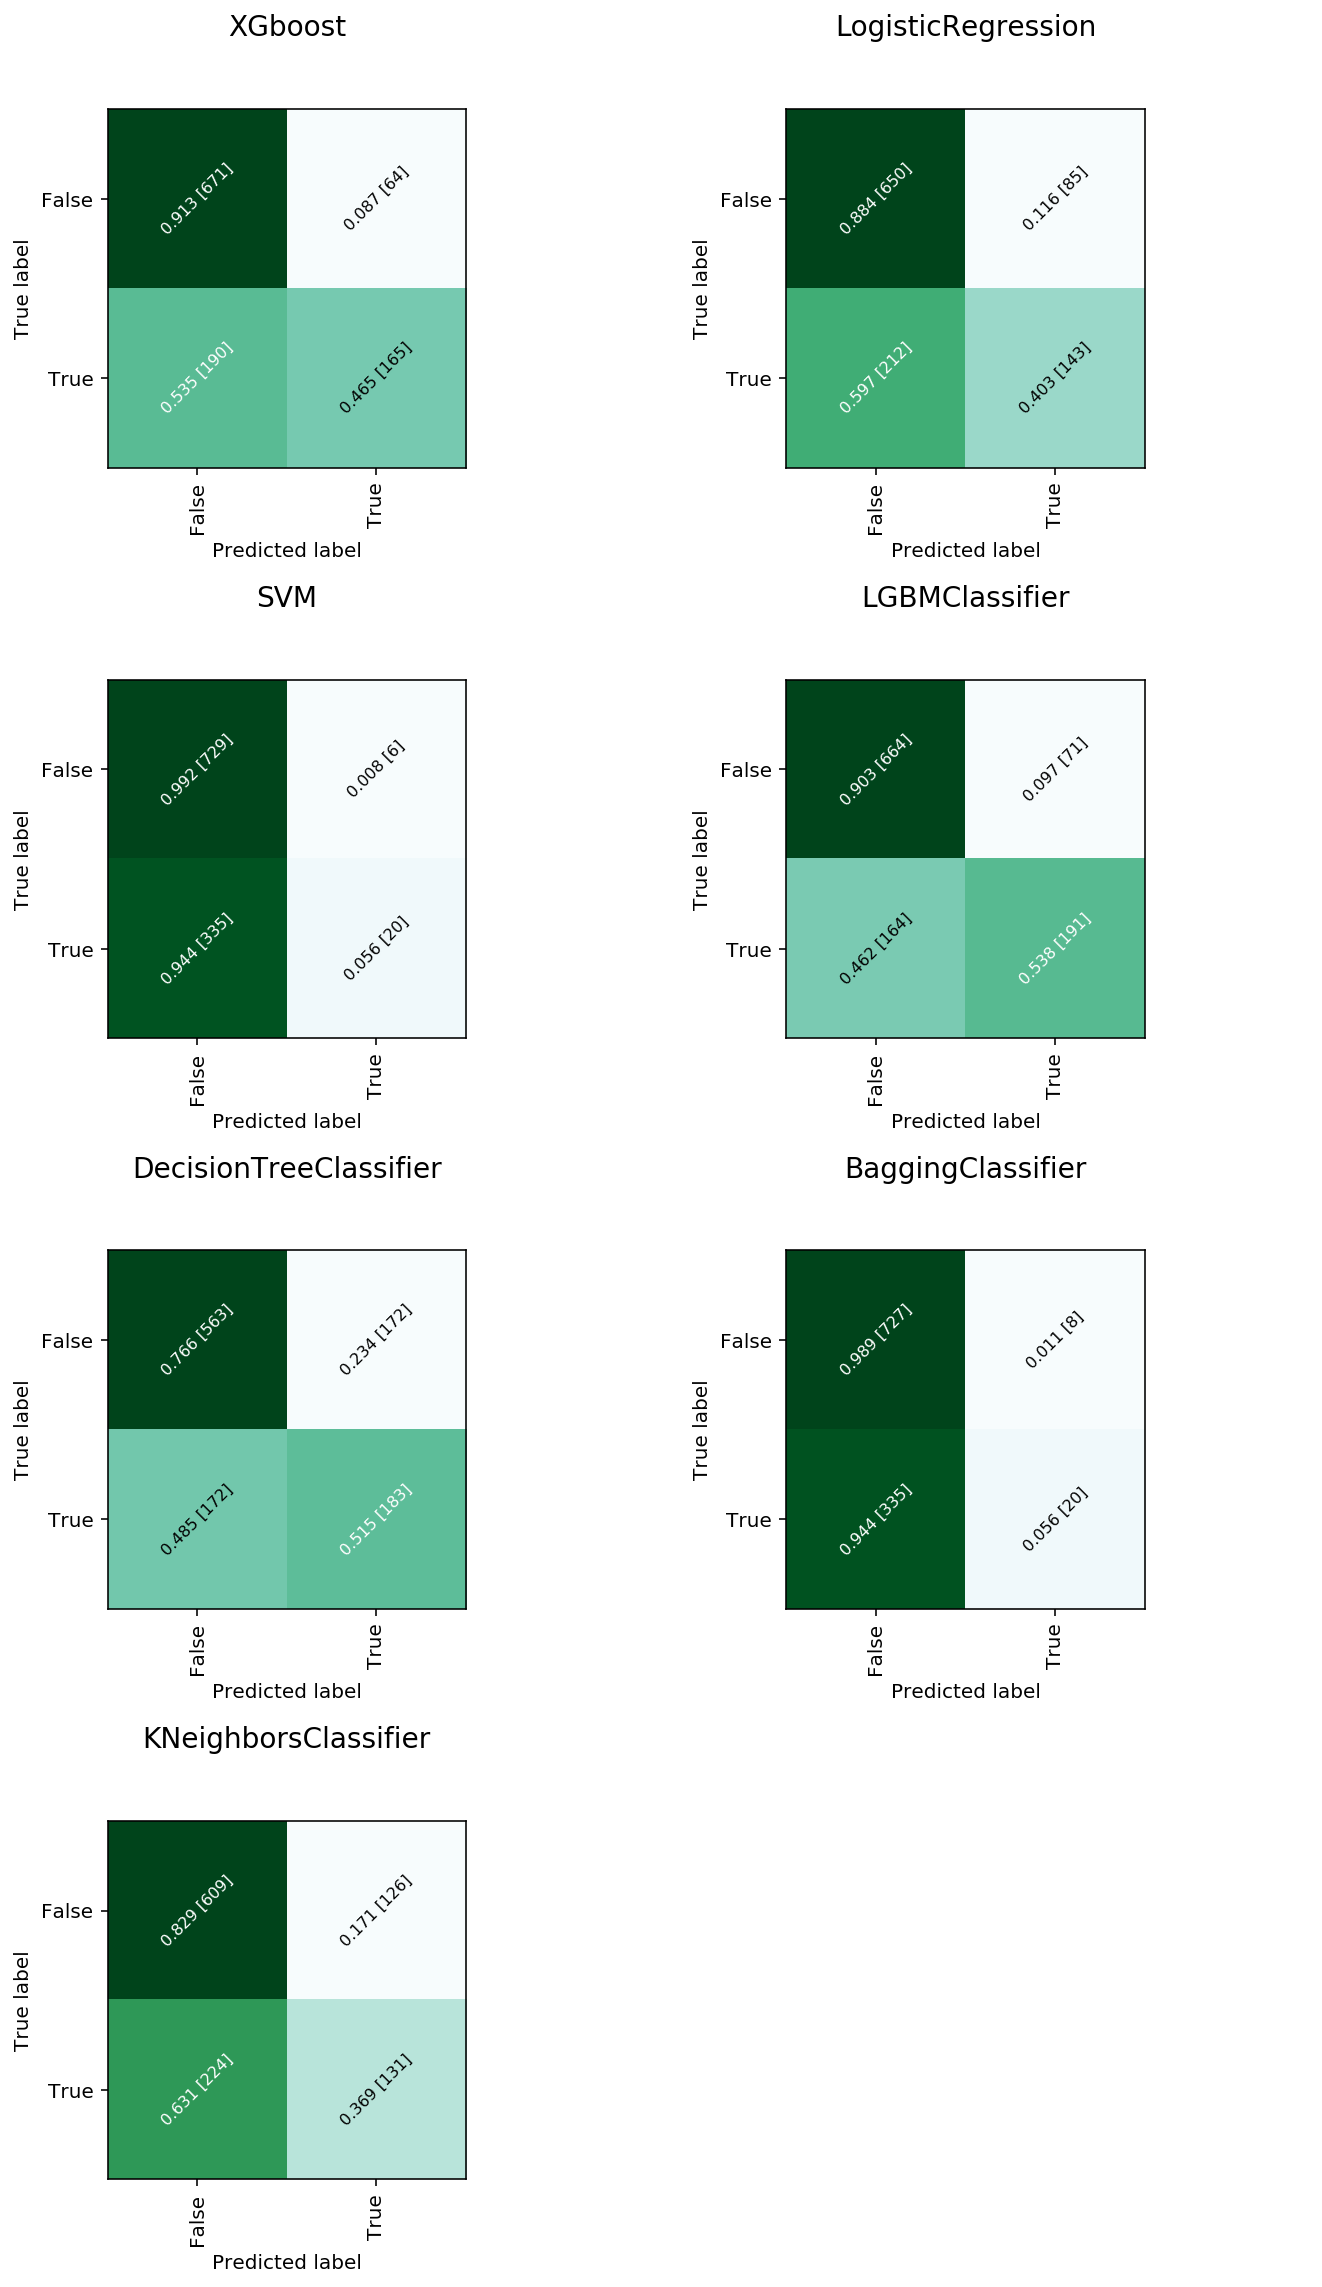

In [403]:
from ads.common.model import ADSModel
from ads.evaluations.evaluator import ADSEvaluator
from ads.dataset.factory import DatasetFactory

train = X_train.merge(y_train, left_index=True, right_index=True)
test = X_test.merge(y_test, left_index=True, right_index=True)
dstr = DatasetFactory.open(train, target="target1")
dste = DatasetFactory.open(test, target="target1")

xgboost = ADSModel.from_estimator(xgboost, name="XGboost")
svc = ADSModel.from_estimator(svc, name="SVM")
lgr = ADSModel.from_estimator(lgr, name="LogisticRegression")
lgbm = ADSModel.from_estimator(lgbm, name="LGBMClassifier")
bagging = ADSModel.from_estimator(bagging, name="BaggingClassifier")
decisionTree = ADSModel.from_estimator(decisionTree, name="DecisionTreeClassifier")
neigh = ADSModel.from_estimator(neigh, name="KNeighborsClassifier")



evaluator = ADSEvaluator(dste, models=[xgboost,lgr,svc,lgbm,decisionTree,bagging,neigh], training_data=dstr)
evaluator.show_in_notebook()
evaluator.metrics